In [60]:
source('helpers.R')
kaggle.house.loadLibraries()

df.combined = kaggle.house.PrepareCombinedDataSet()
df.lot_frontage = df.combined %>% filter(!is.na(LotFrontage))

df.lot_frontage.trimmed = df.lot_frontage %>%
    mutate(
        LotArea.Log.normed = abs(LotArea.Log - mean(LotArea.Log)) / sd(LotArea.Log),
        LotArea.Log.isOutlier = LotArea.Log.normed >= 3) %>%
    filter(LotArea.Log.isOutlier == FALSE) %>%
    select(-LotArea.Log.isOutlier)

In [61]:
colNames = names(which(sapply(df.lot_frontage, is.character)))
colNames = c(colNames, "LotFrontage.Log", "LotArea.Log")

df.rsquared = df.lot_frontage %>% 
    select(colNames) %>% 
    gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
    group_by(attr, attr_val) %>%
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(attr, attr_val, r.squared)

df.freq = df.lot_frontage %>% 
    select(colNames) %>% 
    gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
    group_by(attr, attr_val) %>%
    summarise(n=n())%>%
    mutate(freq = n / sum(n))

df.joint = inner_join(df.rsquared, df.freq, by = c("attr", "attr_val"))
df.joint %>% 
    mutate(freq.rsquared = r.squared * freq) %>% 
    group_by(attr) %>%
    summarise(rsquared.expect = sum(freq.rsquared)) %>%
    arrange(desc(rsquared.expect)) %>% head()

attr,rsquared.expect
LotConfig,0.6512306
LotConfig2,0.6454040
LotShape,0.6092392
LotShape2,0.6000610
LandSlope,0.5976722
LandContour,0.5967093


LotConfig2,r.squared
Corner,0.6090078
CulDSac+FR2+FR3,0.2875249
Inside,0.6848806


LotConfig2,n,freq
Corner,407,0.16728319
CulDSac+FR2+FR3,164,0.06740649
Inside,1862,0.76531032


LotConfig2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Corner,0.6090078,0.6080424,0.1823055,630.82623,1.315209e-84,2,116.23758,-226.4752,-214.4487,13.46029,405
CulDSac+FR2+FR3,0.2875249,0.2831269,0.3564402,65.37638,1.365161e-13,2,-62.51919,131.0384,140.3380,20.58203,162
Inside,0.6848806,0.6847112,0.1959327,4042.52482,0.000000e+00,2,393.96767,-781.9353,-765.3471,71.40467,1860


LotConfig2,LotFrontage.Log,LotArea.Log,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
Corner,4.094345,9.164296,4.369576,0.009037139,-0.2752313,0.002457324,0.1820154,0.002814269,-1.511584
Corner,3.912023,8.911934,4.211891,0.011062713,-0.2998678,0.003682340,0.1819180,0.005018319,-1.647901


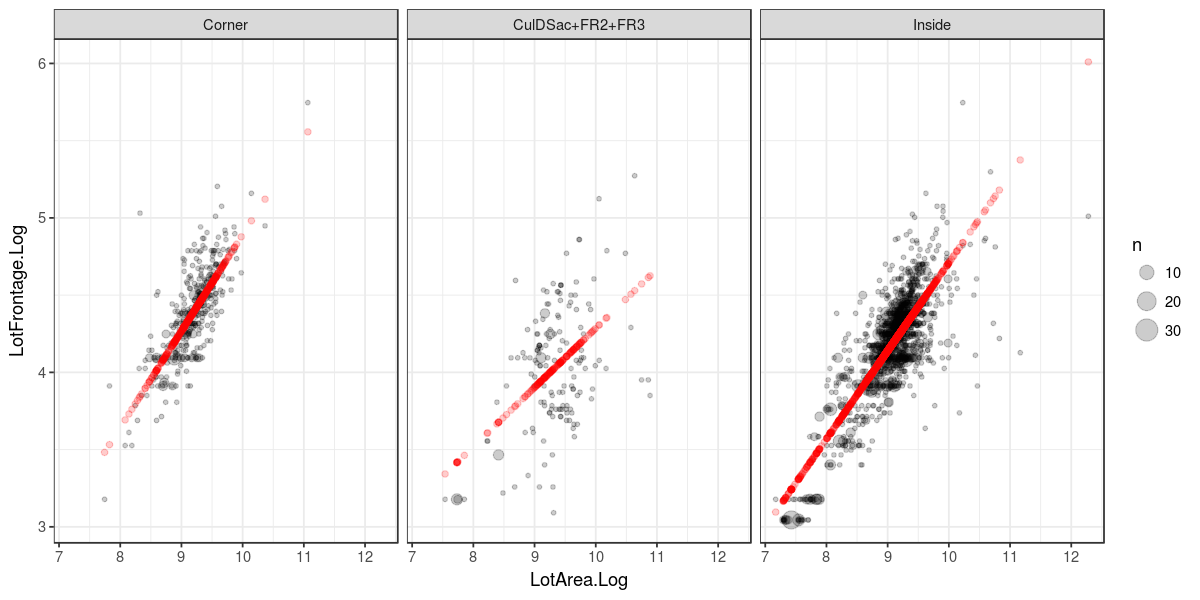

In [27]:
options(repr.plot.width = 10, repr.plot.height = 5)

df.lot_frontage %>% 
    group_by(LotConfig2) %>% 
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(LotConfig2, r.squared)

df.lot_frontage %>% 
    group_by(LotConfig2) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / sum(n))

lm.models = df.lot_frontage %>% 
    group_by(LotConfig2) %>% 
    do(fit = lm(LotFrontage.Log ~ LotArea.Log, data=.))

lm.models %>% glance(fit)

fitted = lm.models %>% augment(fit)
fitted %>% head(2)

ggplot(fitted) +
    geom_count(aes(x=LotArea.Log, y=LotFrontage.Log), alpha=0.2) +
    geom_point(aes(x=LotArea.Log, y=.fitted), alpha=0.2, color="red") +
    facet_wrap(~LotConfig2) +
    theme_bw()

LotConfig2,r.squared
Corner,0.5874429
CulDSac+FR2+FR3,0.3056595
Inside,0.5980018


LotConfig2,n,freq
Corner,406,0.17145270
CulDSac+FR2+FR3,158,0.06672297
Inside,1804,0.76182432


LotConfig2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Corner,0.5874429,0.5864217,0.1822703,575.25836,1.09909e-79,2,116.03283,-226.0657,-214.0466,13.42187,404
CulDSac+FR2+FR3,0.3056595,0.3012085,0.3433345,68.67361,4.99670e-14,2,-54.27601,114.5520,123.7398,18.38906,156
Inside,0.5980018,0.5977787,0.1900381,2680.60675,0.00000e+00,2,436.83240,-867.6648,-851.1715,65.07832,1802


LotConfig2,LotFrontage.Log,LotArea.Log,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
Corner,4.094345,9.164296,4.369106,0.009045933,-0.2747619,0.002463060,0.1819811,0.002812342,-1.509302
Corner,3.912023,8.911934,4.213232,0.011130697,-0.3012092,0.003729176,0.1818761,0.005130181,-1.655631


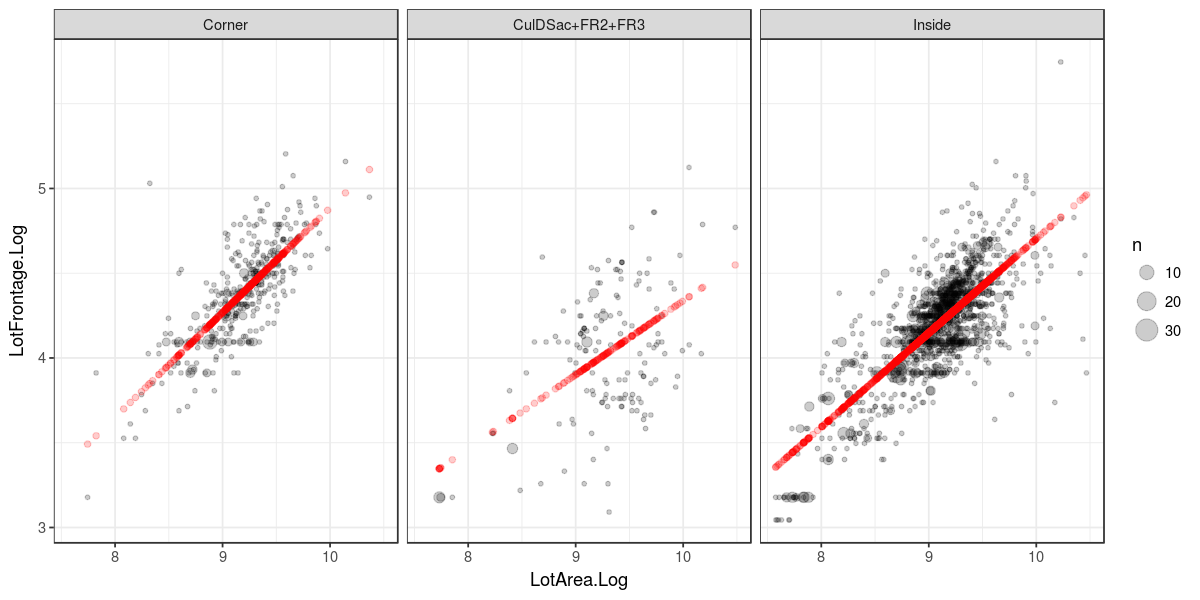

In [62]:
options(repr.plot.width = 10, repr.plot.height = 5)

df.lot_frontage.trimmed %>% 
    group_by(LotConfig2) %>% 
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(LotConfig2, r.squared)

df.lot_frontage.trimmed %>% 
    group_by(LotConfig2) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / sum(n))

lm.models = df.lot_frontage.trimmed %>% 
    group_by(LotConfig2) %>% 
    do(fit = lm(LotFrontage.Log ~ LotArea.Log, data=.))

lm.models %>% glance(fit)

fitted = lm.models %>% augment(fit)
fitted %>% head(2)

ggplot(fitted) +
    geom_count(aes(x=LotArea.Log, y=LotFrontage.Log), alpha=0.2) +
    geom_point(aes(x=LotArea.Log, y=.fitted), alpha=0.2, color="red") +
    facet_wrap(~LotConfig2) +
    theme_bw()

LotShape2,r.squared
Ireg,0.1950226
Reg,0.7656413


LotShape2,n,freq
Ireg,706,0.2901767
Reg,1727,0.7098233


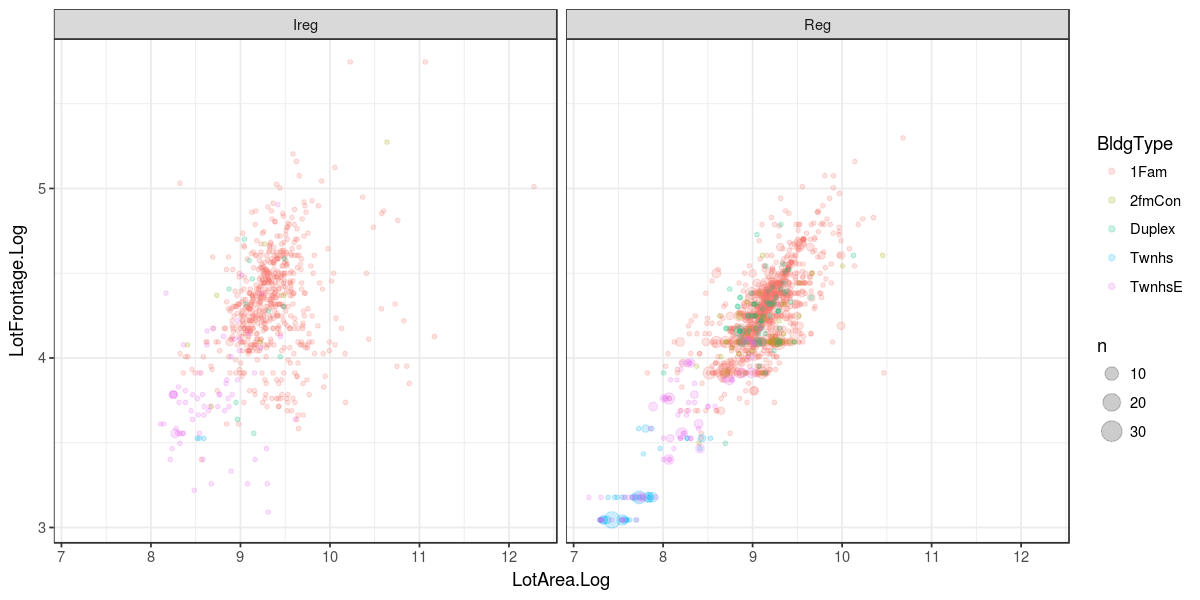

In [27]:
options(repr.plot.width = 10, repr.plot.height = 5)

df.lot_frontage %>% 
    group_by(LotShape2) %>% 
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(LotShape2, r.squared)

df.lot_frontage %>% 
    group_by(LotShape2) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / n.total)

ggplot(df.lot_frontage, aes(x=LotArea.Log, y=LotFrontage.Log)) +
    geom_count(aes(colour = BldgType), alpha=0.2) +
    facet_grid(~LotShape2) +
    theme_bw()

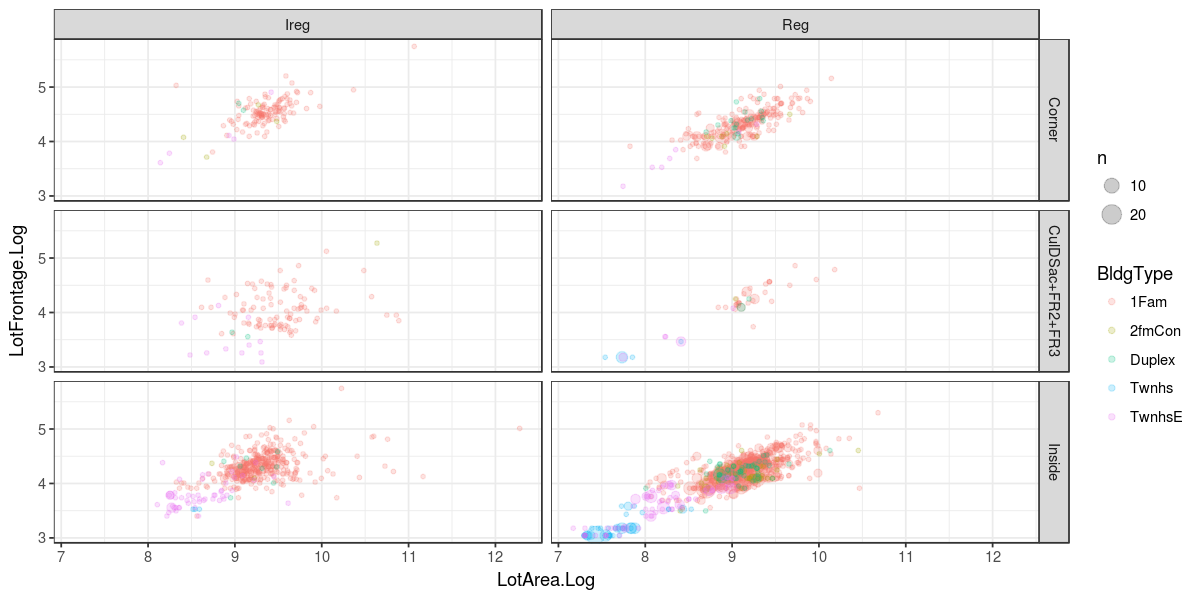

In [6]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df.lot_frontage, aes(x=LotArea.Log, y=LotFrontage.Log)) +
    geom_count(aes(colour = BldgType), alpha=0.2) +
    facet_grid(LotConfig2~LotShape2) +
    theme_bw()

In [23]:
df.rsquared = df.lot_frontage %>% 
    group_by(LotConfig2, LotShape2) %>% 
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(LotConfig2, LotShape2, r.squared)

n.total = df.lot_frontage %>% summarise(n=n())
n.total = n.total$n

df.freq = df.lot_frontage %>% 
    group_by(LotConfig2, LotShape2) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / n.total) 

df.rsquared
df.freq

df.joint = 
    inner_join(df.rsquared, df.freq, by = c("LotConfig2", "LotShape2")) %>% 
    mutate(freq.rsquared = r.squared * freq)

df.joint

sum(df.joint$freq.rsquared)

LotConfig2,LotShape2,r.squared
Corner,Ireg,0.45332168
Corner,Reg,0.62402057
CulDSac+FR2+FR3,Ireg,0.09454551
CulDSac+FR2+FR3,Reg,0.92206654
Inside,Ireg,0.33510098
Inside,Reg,0.77629462


LotConfig2,LotShape2,n,freq
Corner,Ireg,130,0.05343198
Corner,Reg,277,0.11385121
CulDSac+FR2+FR3,Ireg,110,0.04521167
CulDSac+FR2+FR3,Reg,54,0.02219482
Inside,Ireg,466,0.19153309
Inside,Reg,1396,0.57377723


LotConfig2,LotShape2,r.squared,n,freq,freq.rsquared
Corner,Ireg,0.45332168,130,0.05343198,0.02422187
Corner,Reg,0.62402057,277,0.11385121,0.07104550
CulDSac+FR2+FR3,Ireg,0.09454551,110,0.04521167,0.00427456
CulDSac+FR2+FR3,Reg,0.92206654,54,0.02219482,0.02046510
Inside,Ireg,0.33510098,466,0.19153309,0.06418292
Inside,Reg,0.77629462,1396,0.57377723,0.44542018


[1] 0.6296101